# CUSTOMER SEGMENTATION 
<br>
We use RFM analysis and unsupervised machine learning KMeans to perform customer segmentation on the online transaction dataset from <a href="https://www.kaggle.com/datasets/marian447/retail-store-sales-transactions">Kaggle</a>. We also conduct Cohort analysis to overview the retention rate and prepare flat file for visualization on Power BI.


In [2]:
import pandas as pd
import numpy as np
from operator import attrgetter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

<b><u>1. Dataset information:</u></b>
<br>
The final dataset we use to analyze contains 131,706 observations and 7 variables:
<ul>
    <li><b>Date</b>: transaction date from Jan 02, 2016 to Dec 31,2016;</li>
    <li><b>Customer_ID</b>: a unique number that identifies each customer;</li>
    <li><b>Transaction_ID</b>: a unique number that identifies each transaction;</li>
    <li><b>SKU_Category</b>: a string code that identifies one SKU (stocking keeping unit) category;</li>
    <li><b>SKU</b>: a string code that identifies one SKU;</li>
    <li><b>Quantity</b>: units of sold item;</li>
    <li><b>Sales_Amount</b>: total sales amount in USD;</li>
</ul>
There are 22,625 customers do online shopping with 64,682 transaction in one-year period.<br>On average, one customer buys 8.65 units and pays 69.75 USD, one transaction contains 3.02 units and costs 24.4 USD. 50% of customers buy less than or equal to 3 units and pay no more than 23.85 USD while 50% of transactions contain less than or equal to 2 units and costs no more than 12.21 USD.        

In [3]:
df = pd.read_csv("C:/Users/Admin/Python/Dataset/scanner_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      131706 non-null  int64  
 1   Date            131706 non-null  object 
 2   Customer_ID     131706 non-null  int64  
 3   Transaction_ID  131706 non-null  int64  
 4   SKU_Category    131706 non-null  object 
 5   SKU             131706 non-null  object 
 6   Quantity        131706 non-null  float64
 7   Sales_Amount    131706 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 8.0+ MB


In [4]:
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
df.drop('Unnamed: 0',axis=1)
df.to_csv("C:/Users/Admin/Python/Dataset/scanner_trans.csv")

In [5]:
print(10*"*" + "SUMMARY STATISTICS" + 10*"*" + '\n')

print(5*"*" + "Transaction Date: \n")
print(df[['Date']].describe(datetime_is_numeric=True).loc[['min','max']],"\n")

print(5*"*" + "Number of Customers: ",df['Customer_ID'].nunique(),"\n")
print(5*"*" + "Number of Transactions: ",df['Transaction_ID'].nunique(),"\n")
n_orders = df.groupby('Customer_ID')['Transaction_ID'].nunique()
mult_orders = np.sum(n_orders > 1)/df['Customer_ID'].nunique()*100
print(f'{mult_orders:.2f}% customers ordered more than once\n')

print(5*"*" + "Quantity Sold and Sales Amount: " + "\n")
df1 = df.groupby('Customer_ID').agg({'Quantity':'sum','Sales_Amount':'sum'})
sum1 = df1.describe()
sum1.columns = ['Cust_Quantity','Cust_Sales_Amount']
df2 = df.groupby('Transaction_ID').agg({'Quantity':'sum','Sales_Amount':'sum'})
sum2 = df2.describe()
sum2.columns = ['Trans_Quantity','Trans_Sales_Amount']
summ = sum1.merge(sum2,left_index=True,right_index=True)
print(summ)

**********SUMMARY STATISTICS**********

*****Transaction Date: 

                    Date
min  2016-01-02 00:00:00
max  2016-12-31 00:00:00 

*****Number of Customers:  22625 

*****Number of Transactions:  64682 

49.02% customers ordered more than once

*****Quantity Sold and Sales Amount: 

       Cust_Quantity  Cust_Sales_Amount  Trans_Quantity  Trans_Sales_Amount
count   22625.000000       22625.000000    64682.000000        64682.000000
mean        8.646384          69.747563        3.024403           24.396874
std        20.984511         152.307769        6.298796           38.613117
min         0.330000           0.140000        0.100000            0.030000
25%         2.000000          10.170000        1.000000            6.360000
50%         3.000000          23.850000        2.000000           12.210000
75%         8.000000          63.070000        3.000000           25.180000
max       814.900000        3985.940000      408.000000          707.730000


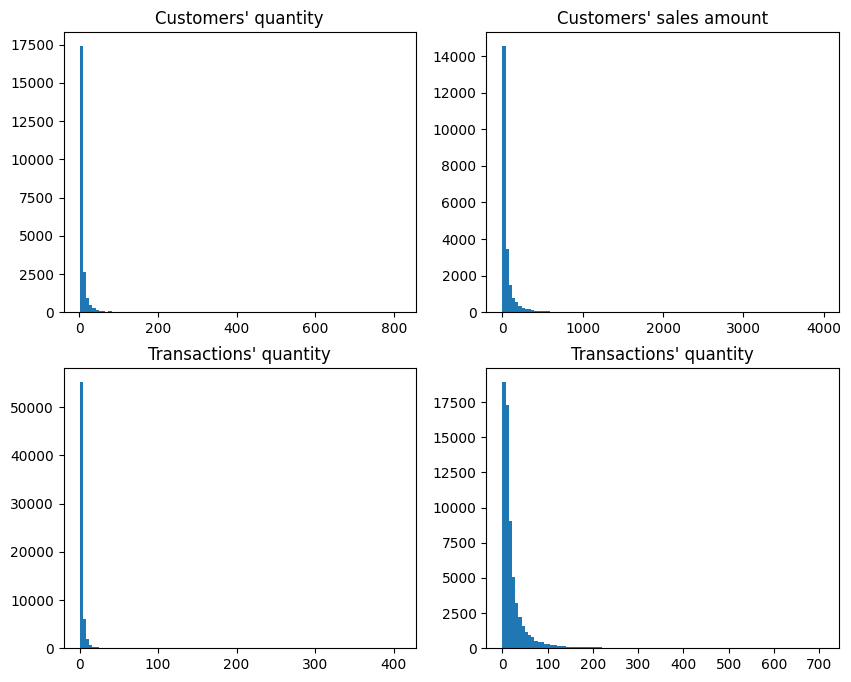

In [6]:
#Plotting:
fig,ax = plt.subplots(2,2,figsize=(10,8))
ax[0,0].hist(df1['Quantity'],bins=100)
ax[0,0].set_title('Customers\' quantity')
ax[0,1].hist(df1['Sales_Amount'],bins=100)
ax[0,1].set_title('Customers\' sales amount')
ax[1,0].hist(df2['Quantity'],bins=100)
ax[1,0].set_title('Transactions\' quantity')
ax[1,1].hist(df2['Sales_Amount'],bins=100)
ax[1,1].set_title('Transactions\' quantity')
plt.show()

<b><u>2. Cohort Analyis:</u></b>
<br>
We divide customers into cohorts based on their first transaction month and calculate each cohort's customer and revenue retention rate on the following months.<br> The cohort charts below show that both the customer retention rates and the revenue retention rates drop significantly over the months.<br>38% of 3,396 customers in 'Jan 2016' cohort and only 14% of 1185 customers in 'Nov 2016' cohort continues to make transactions on the next month; on Dec 2016, merely 1% of the 1st cohort stay and create a total sales of 1,680.03 USD which is equivalent to 2% of Jan 2016' total sales.


In [7]:
# Cohort Analysis:
df['month_order'] = df['Date'].dt.to_period('M')
df['first_month'] = df.groupby('Customer_ID')['month_order'].transform('min')
df['month_index'] = (df['month_order'] - df['first_month']).apply(attrgetter('n'))
cohort = df.groupby(['first_month','month_index']).agg({'Customer_ID':pd.Series.nunique,'Sales_Amount':'sum'}).reset_index()
cohort.columns = ['first_month','month_index','n_cust','Total_Sales']
cohort

,first_month,month_index,n_cust,Total_Sales
0,2016-01,0,3396,111200.28
1,2016-01,1,1306,58780.45
2,2016-01,2,1025,38342.51
3,2016-01,3,597,20109.05
4,2016-01,4,266,9130.26
...,...,...,...,...
73,2016-10,1,191,4768.85
74,2016-10,2,204,6152.50
75,2016-11,0,1185,26494.56
76,2016-11,1,166,5502.19


In [12]:
#Customer retention
cust_pivot = cohort.pivot_table(index = 'first_month', columns = 'month_index',values = 'n_cust')
cust0 = cust_pivot.iloc[:,0]
cust = cust_pivot.divide(cust0,axis=0)
cust_pivot

month_index,0,1,2,3,4,5,6,7,8,9,10,11
first_month,,,,,,,,,,,,
2016-01,3396.0,1306.0,1025.0,597.0,266.0,197.0,152.0,137.0,90.0,56.0,41.0,40.0
2016-02,2221.0,478.0,291.0,147.0,95.0,68.0,68.0,57.0,22.0,18.0,14.0,NaN
2016-03,2642.0,746.0,651.0,600.0,530.0,521.0,530.0,512.0,513.0,532.0,NaN,NaN
2016-04,2527.0,728.0,633.0,553.0,566.0,595.0,566.0,567.0,581.0,NaN,NaN,NaN
2016-05,2626.0,626.0,559.0,505.0,566.0,551.0,521.0,523.0,NaN,NaN,NaN,NaN
2016-06,1569.0,278.0,274.0,280.0,278.0,277.0,300.0,NaN,NaN,NaN,NaN,NaN
2016-07,1213.0,172.0,183.0,189.0,182.0,201.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-08,1060.0,163.0,138.0,143.0,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09,1625.0,309.0,263.0,297.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


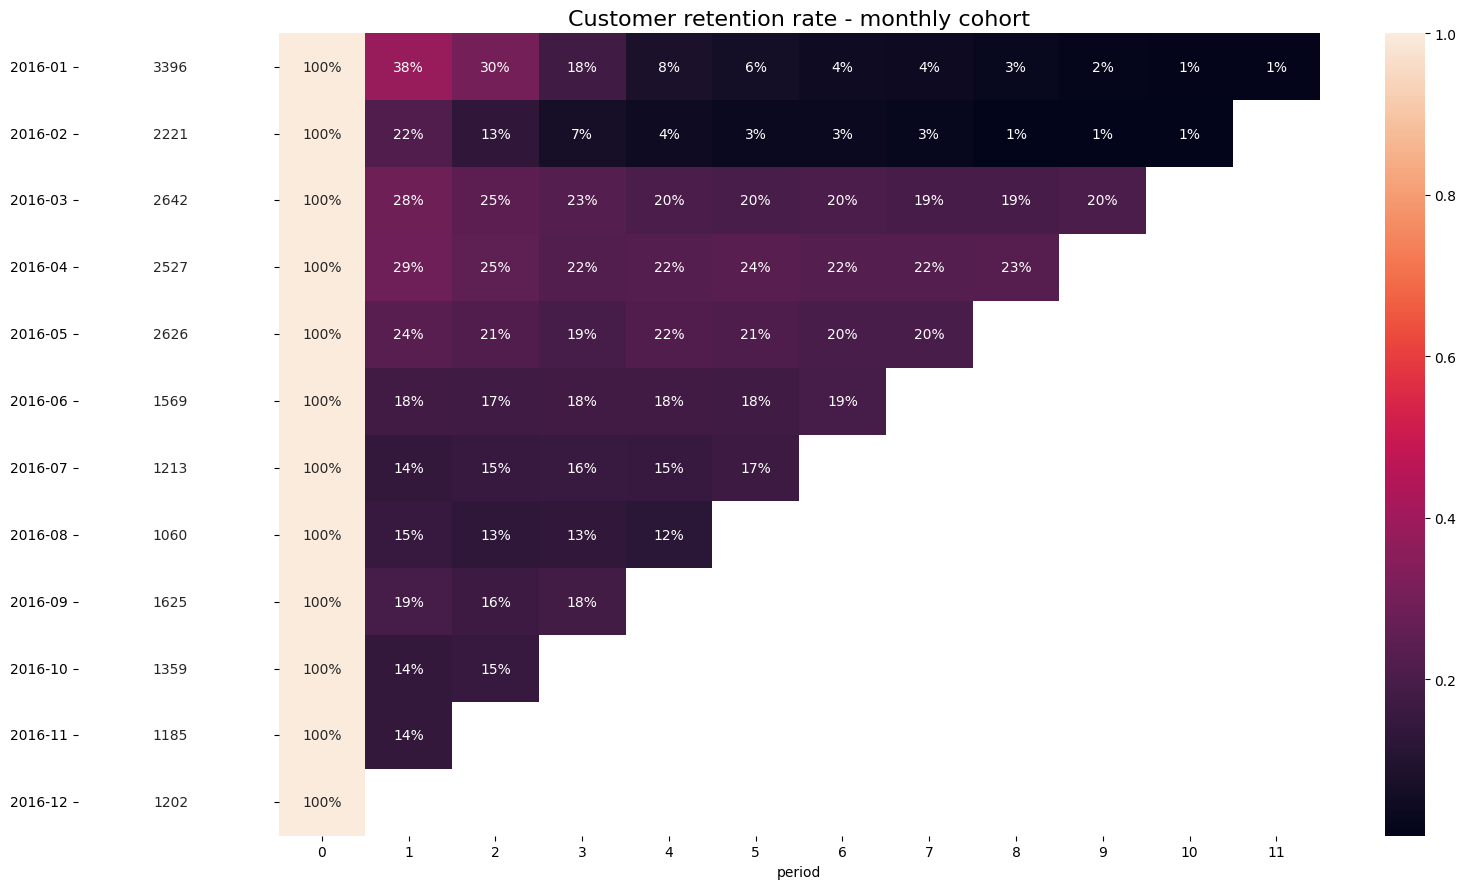

In [13]:
%matplotlib inline
fig, ax = plt.subplots(1,2,figsize=(16,9),sharey=True,gridspec_kw={'width_ratios':[2,14]})

sns.heatmap(cust,
           mask = cust.isnull(),
           annot = True,
           fmt = '.0%',
           ax = ax[1])
ax[1].set_title('Customer retention rate - monthly cohort', fontsize = 16)
ax[1].set(xlabel = 'period',
         ylabel = '')

cust0_df = pd.DataFrame(cust0)
white_cmap = mcolors.ListedColormap(['white'])
sns.heatmap(cust0_df,
           annot = True,
           fmt = 'g',
           cbar = False,
            cmap = white_cmap,
           ax = ax[0])
ax[0].set(xlabel = '',
         ylabel = '',xticks=[])

fig.tight_layout()
plt.show()

In [10]:
# revenue retention
rev_pivot = cohort.pivot_table(index = 'first_month', columns = 'month_index',values = 'Total_Sales')
rev0 = rev_pivot.iloc[:,0]
rev = rev_pivot.divide(rev0,axis=0)
rev_pivot

month_index,0,1,2,3,4,5,6,7,8,9,10,11
first_month,,,,,,,,,,,,
2016-01,111200.28,58780.45,38342.51,20109.05,9130.26,7568.49,5576.84,4446.45,3326.49,2005.99,1268.04,1680.03
2016-02,63334.16,13736.82,9124.20,3732.70,3196.31,1929.70,1674.35,1182.10,514.55,273.42,316.15,NaN
2016-03,75845.21,36262.14,34557.78,31218.18,30021.19,27992.31,30741.94,31084.99,26630.91,31933.69,NaN,NaN
2016-04,72676.72,28625.37,27020.14,23337.34,23614.39,26157.00,27332.27,24928.57,27805.80,NaN,NaN,NaN
2016-05,66673.75,23432.24,20468.87,19228.88,20584.52,20824.51,20597.23,19189.50,NaN,NaN,NaN,NaN
2016-06,38869.99,9200.57,7987.78,8165.20,8706.96,9634.16,10063.94,NaN,NaN,NaN,NaN,NaN
2016-07,30057.46,4198.87,5786.30,4786.78,4996.17,6222.81,NaN,NaN,NaN,NaN,NaN,NaN
2016-08,27765.95,5026.48,4432.84,4575.91,4468.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09,40269.86,8939.53,8715.51,10878.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


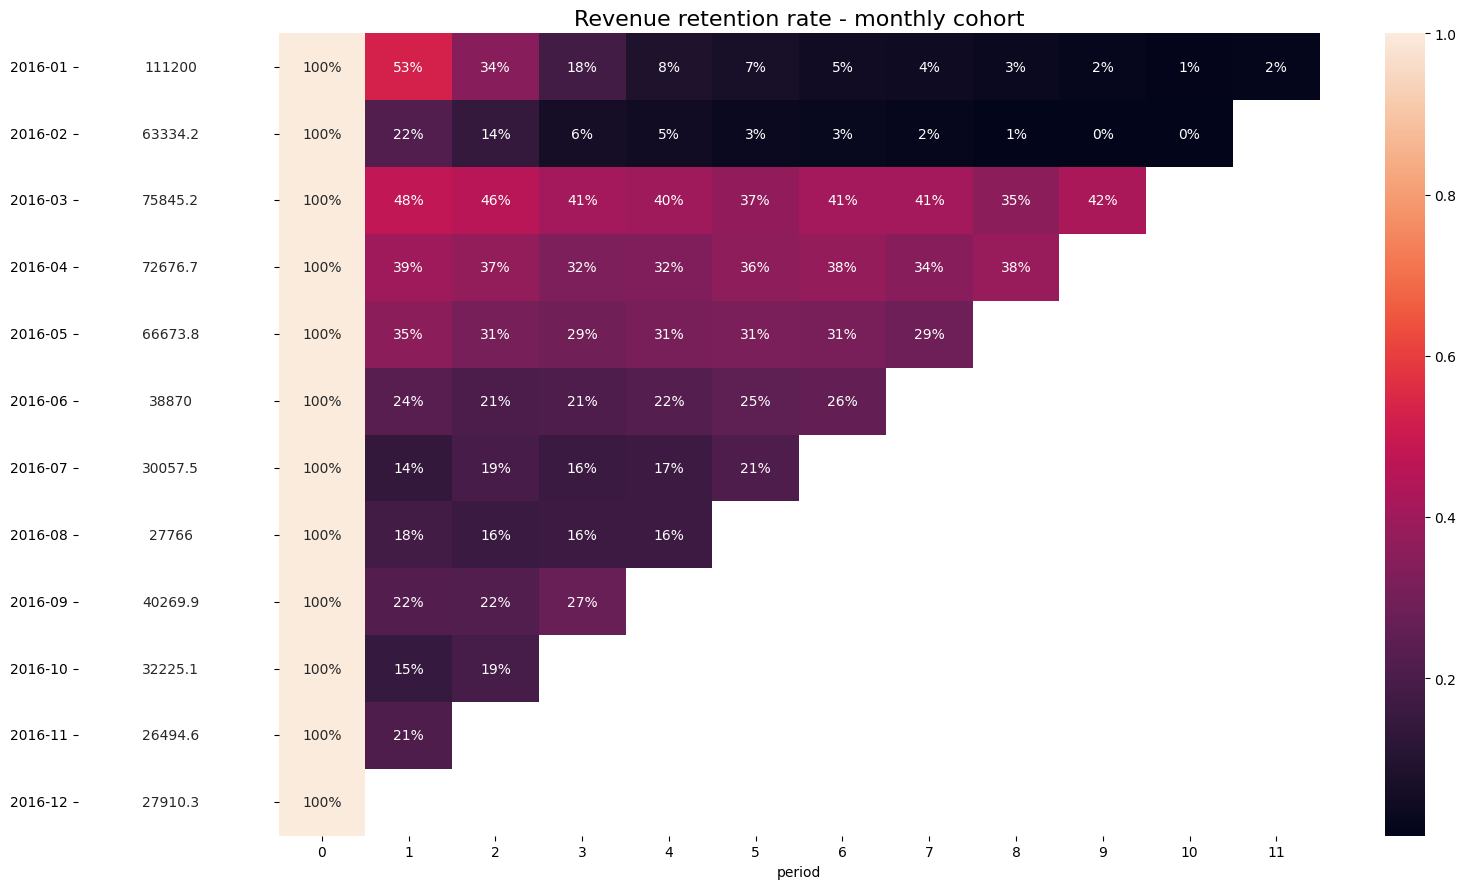

In [11]:
fig, ax = plt.subplots(1,2,figsize=(16,9),sharey=True,gridspec_kw={'width_ratios':[2,14]})

sns.heatmap(rev,
           mask = rev.isnull(),
           annot = True,
           fmt = '.0%',
           ax = ax[1])
ax[1].set_title('Revenue retention rate - monthly cohort', fontsize = 16)
ax[1].set(xlabel = 'period',
         ylabel = '')

rev0_df = pd.DataFrame(rev0)
white_cmap = mcolors.ListedColormap(['white'])
sns.heatmap(rev0_df,
           annot = True,
           fmt = 'g',
           cbar = False,
            cmap = white_cmap,
           ax = ax[0])
ax[0].set(xlabel = '',
         ylabel = '',xticks=[])

fig.tight_layout()
plt.show()

<b><u>3. RFM Analysis:</u></b>
<br>
Based on the original dataset, we build up RFM score to prioritize customers.<br> This method needs 4 parameters:
<ul>
    <li><b>Customer identification</b>: a unique id or customer's name;</li>
    <li><b>Recency</b>: the latest day purchased;</li>
    <li><b>Frequency</b>: total number of transactions;</li>
    <li><b>Monetary</b>: total spending or average spending on each unit sold (we use the latter in this project)</li>
</ul>
To define RFM score, we calculate the quintile of each feature's value (R,F,M) with 1 is the lowest (number) or oldest (time) and 5 is the highest (number) or most recent (time).<br>
On the first sight at the 3 features'value, one average customer buy around 3 times and pay 9.17 USD from Jan 02, 2016 to Dec 31,2016, the average recency is about 162 days away from Jan 01,2017. There are people who buy once from the very first day and there are people who just purchase on the very last day of the period. The maximum frequency of individual transaction is 99 times. The highest average spending is 242.75 USD and the lowest is 0.041 USD.<br>
As both 1st quintile and 2nd quintile group of Frequency value are 1, this feature is divided into 4 groups instead of 5 groups.<br> The Recency value are scored descendingly.


In [14]:
# RFM analysis:
rfm = df.groupby('Customer_ID',as_index=False).agg({'Date':'max','Transaction_ID':pd.Series.nunique,'Sales_Amount':'sum','Quantity':'sum'})
rfm['Monetary'] = rfm['Sales_Amount'].div(rfm['Quantity'])
rfm.drop(['Sales_Amount','Quantity'],axis=1,inplace=True)
rfm.columns = ['Customer_ID','LastDate','Frequency','Monetary']
d0 = pd.Timestamp(2017,1,1)
rfm['Recency'] = rfm['LastDate'].apply(lambda x: (d0-x).days)
rfm.drop('LastDate',axis=1,inplace=True)
perc = [0.2,0.4,0.6,0.8]
rfm[['Recency','Frequency','Monetary']].describe(percentiles=perc)


,Recency,Frequency,Monetary
count,22625.000000,22625.000000,22625.000000
mean,162.097061,2.858873,9.166923
std,115.923611,4.000157,9.378134
min,1.000000,1.000000,0.040900
20%,35.000000,1.000000,4.430000
40%,101.000000,1.000000,6.130000
50%,150.000000,1.000000,6.969167
60%,211.000000,2.000000,7.984000
80%,289.000000,4.000000,11.500000
max,365.000000,99.000000,242.750000


Based on each component's score, we get the RFM score (e.g. if R score, F score and M score are all equal to 1, RFM score is 111). We use the definitions <a href="https://www.putler.com/rfm-analysis/">here</a> to segment the customers into 10 sub-groups. To simplify, we just focus on Recency and Frequency.<br> The number of customers in each sub-groups shown below gives an alert as hibernating group (who bought long time ago and spend low money) and at-risk group (who bought long time ago) has the highest number of customers. Summarize RFM average value of each customer group and look at the charts below, the recent shopper group (new-customer, promising and potential loyal) and about-to-sleep group (below average recency and frequency values) has the monetary values above arage. It's necessary that we should conduct on some reconnect projects, membership/loyalty programs and offer some discounts.

In [18]:
#Score:
rfm['R_score'] = pd.qcut(rfm['Recency'],5,labels=['5','4','3','2','1']).astype('str')
rfm['F_score'] = pd.cut(rfm['Frequency'],
                        bins = [-1,
                                np.percentile(rfm['Frequency'],40),
                                np.percentile(rfm['Frequency'],60),
                                np.percentile(rfm['Frequency'],80),
                                np.max(rfm['Frequency'])],
                        labels=['1','3','4','5']).astype('str')
rfm['M_score'] = pd.qcut(rfm['Monetary'],5,labels=['1','2','3','4','5']).astype('str')
rfm['RFM_score'] = rfm['R_score'] + rfm['F_score'] + rfm['M_score']
rfm['RF_score'] = rfm['R_score'] + rfm['F_score'] 
seg_map = {
    r'5[4-5]':'champion',
    r'[3-4][4-5]':'loyal customer',
    r'[4-5][2-3]':'potential loyal',
    r'41':'promising',
    r'51':'new customer',
    r'33':'need attention',
    r'3[1-2]':'about to sleep',
    r'[1-2]5':'can\'t lose',
    r'[1-2][3-4]':'at risk',
    r'[1-2][1-2]':'hibernating'
}
rfm['segment'] = rfm['RF_score'].replace(seg_map,regex=True)
rfm.drop('RF_score',axis=1,inplace=True)

print(5*"*" + "RFM TABLE: \n")
print(rfm.head(),"\n")
print(5*"*" + "Number of Customers in each Group: \n")
print(rfm['segment'].value_counts())

*****RFM TABLE: 

   Customer_ID  Frequency  Monetary  Recency R_score F_score M_score  \
0            1          1     8.145      345       1       1       4   
1            2          2    11.385      196       3       3       4   
2            3          1     2.730      365       1       1       1   
3            4          2     6.658       53       4       3       3   
4            5          5     5.630      180       3       5       2   

  RFM_score          segment  
0       114      hibernating  
1       334   need attention  
2       111      hibernating  
3       433  potential loyal  
4       352   loyal customer   

*****Number of Customers in each Group: 

hibernating        5724
at risk            2690
champion           2653
loyal customer     2561
about to sleep     2518
promising          2087
potential loyal    1626
new customer       1206
need attention      963
can't lose          597
Name: segment, dtype: int64


In [20]:
rfm_summary = rfm.groupby('segment',as_index = False)[['Recency','Frequency','Monetary']].mean()
rfm_summary.head(10).sort_values('Monetary',ascending=False)

,segment,Recency,Frequency,Monetary
7,new customer,18.435323,1.000000,9.948751
0,about to sleep,155.361001,1.000000,9.605919
8,potential loyal,46.487085,2.000000,9.355907
9,promising,69.465261,1.000000,9.249420
4,hibernating,292.100454,1.000000,9.168935
3,champion,15.526951,8.931021,9.029504
5,loyal customer,95.930496,5.236236,8.986003
1,at risk,283.047584,2.548699,8.804379
2,can't lose,274.790620,6.715243,8.742078
6,need attention,154.880582,2.000000,8.665917


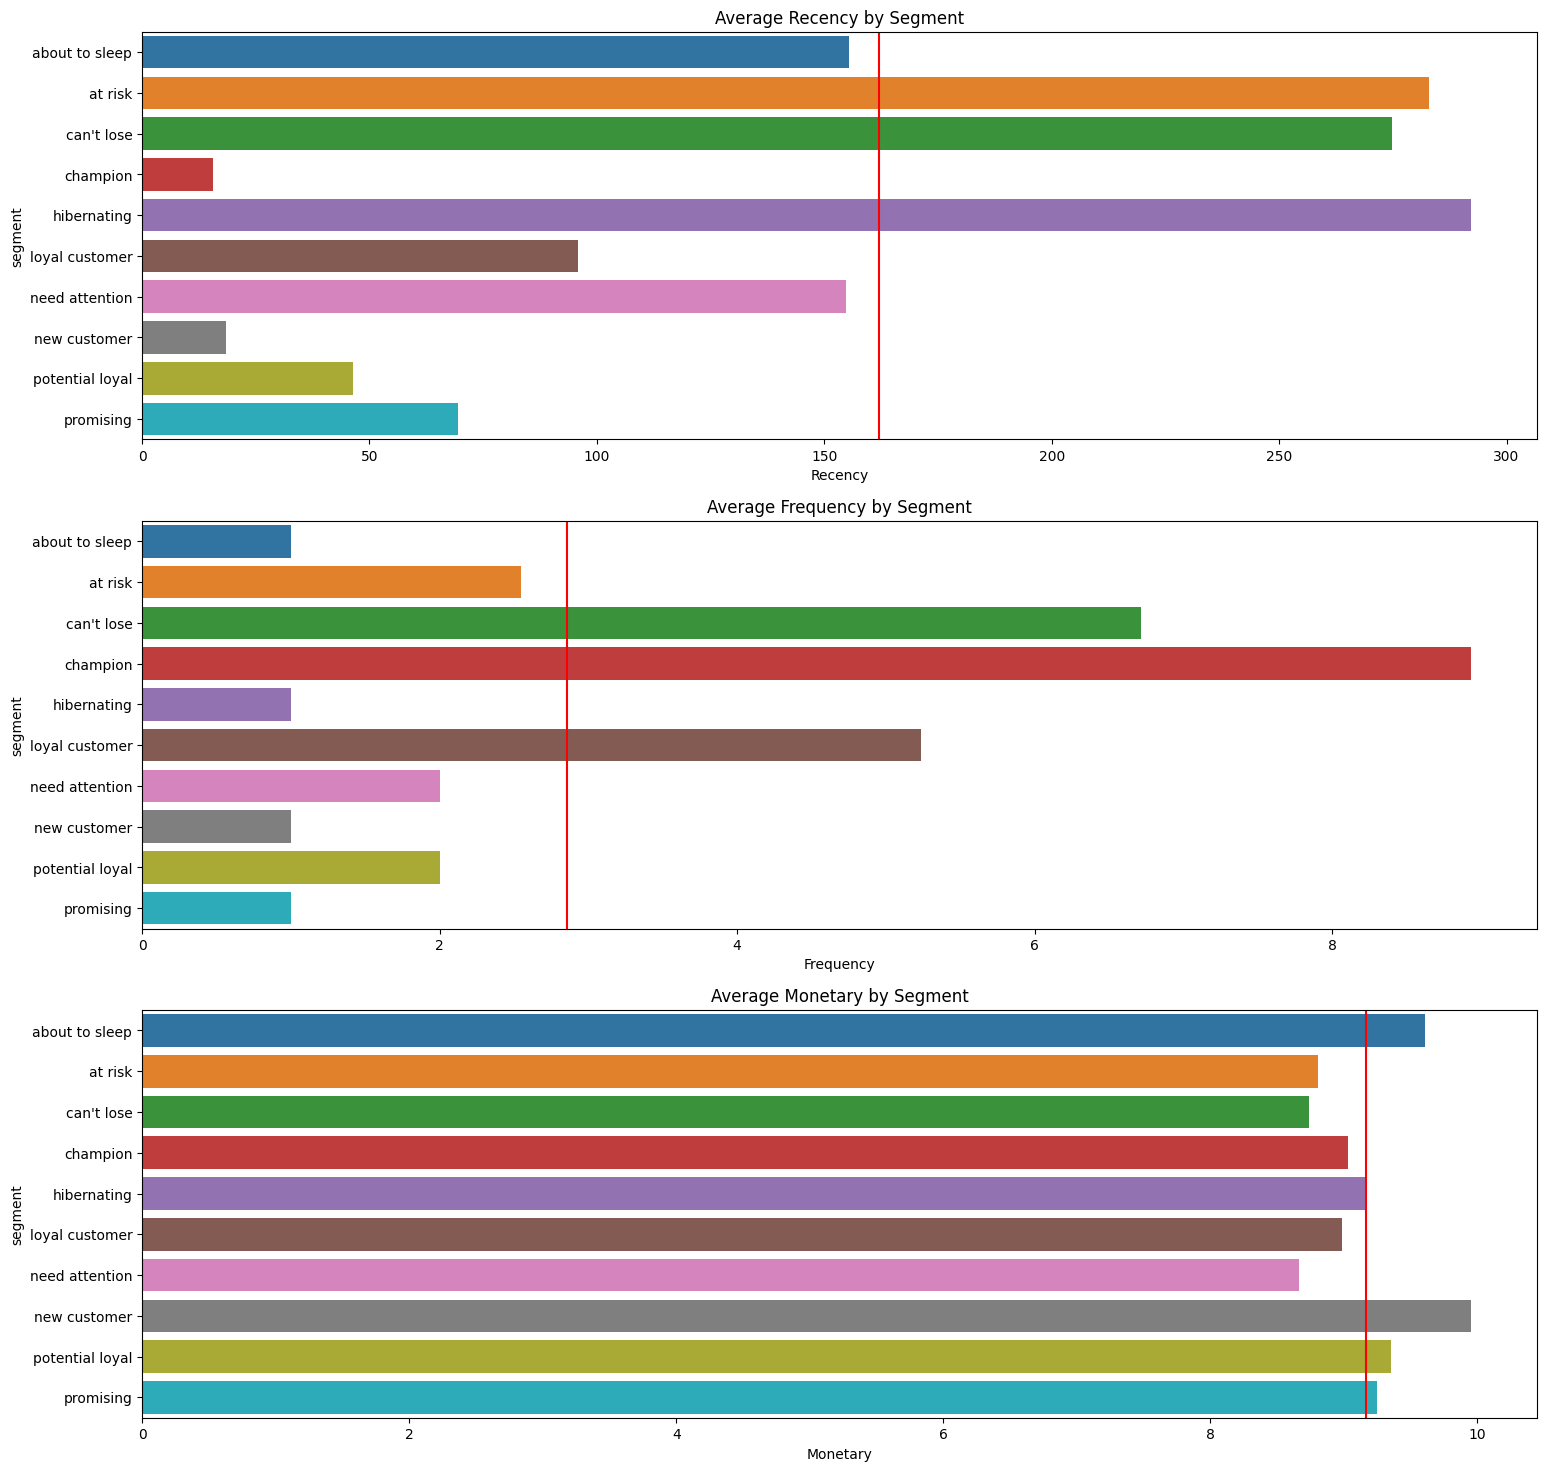

In [83]:
#Plot:
fig, ax = plt.subplots(3,1,figsize=(18,18))

sns.barplot(x='Recency',y='segment',data=rfm_summary,ax=ax[0])
ax[0].axvline(x=np.mean(rfm['Recency']),color = 'r')
ax[0].set_title('Average Recency by Segment')

sns.barplot(x='Frequency',y='segment',data=rfm_summary,ax=ax[1])
ax[1].axvline(x=np.mean(rfm['Frequency']),color = 'r')
ax[1].set_title('Average Frequency by Segment')

sns.barplot(x='Monetary',y='segment',data=rfm_summary,ax=ax[2])
ax[2].axvline(x=np.mean(rfm['Monetary']),color = 'r')
ax[2].set_title('Average Monetary by Segment')

plt.show()

<b><u>4. KMeans Clustering: </u></b>
<br>
Another approach for customer segmentation is to use KNN model.This method generates clusters based on the patterns of dataset itself instead of pre-defined standard. As KNN model requires each feature's values must have the same scale, we conduct 3-step process:
<ul>
    <li><b>First</b>, normalize data;</li>
    <li><b>Next</b>, choose approriate number of clusters using inertia plot;</li>
    <li><b>Finally</b>, initiate and fit KNN model to the data and figure out each cluster's characteristic</li>
</ul>
The histogram of Recency, Frequency and Monetary value shows that the 3 features are left-skewed so we must unskew them (by taking log) before normalizing.<br> Plotting sum squared error of KMeans models with number of clusters ranging from 1 to 10, we choose 4 (the elbow point) to be the approriate number of customer group.<br>
The snake plot below shows 4 clusters:
<ul>
    <li><b>Cluster 0</b>: average Recency and Frequency value, low Monetary value (with 9,486 customers);</li>
    <li><b>Cluster 1</b>: average Recency and Frequency value, high Monetary value (with 6,436 customers);</li>
    <li><b>Cluster 2</b>: high Frequency value, average Monetary value, average Recency value (with 3,950 customers);</li>
    <li><b>Cluster 3</b>: high Frequency value, average Monetary value, low Recency value (with 2,753 customers)</li>
</ul>
With Cluster 0 and Cluster 1, we can promote some membership/loyalty programs, give out some time-limited offers to Cluster 0 especially. With Cluster 2 and Cluster 3, beside offering some discount programs, we can run some reconnect programs (especially personalized email for Cluster 3), product recommendation based on their history purchase.

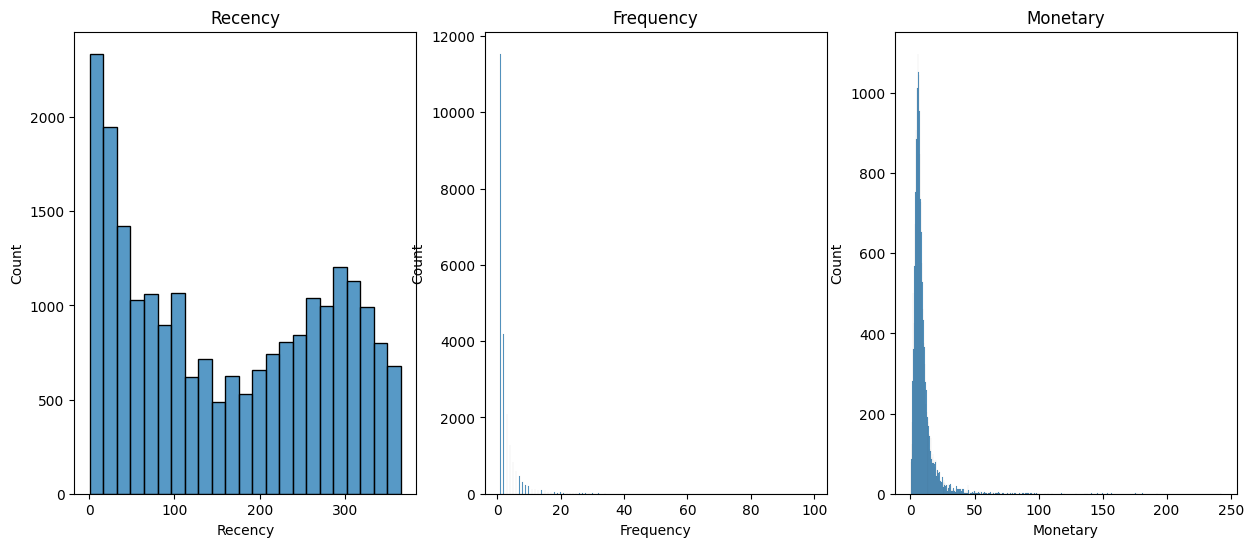

In [21]:
cluster = rfm.drop(['R_score','F_score','M_score','RFM_score'],axis=1)
#Plot:
fig,ax = plt.subplots(1,3,figsize = (15,6))
sns.histplot(cluster['Recency'],ax=ax[0])
ax[0].set_title('Recency')
sns.histplot(cluster['Frequency'],ax=ax[1])
ax[1].set_title('Frequency')
sns.histplot(cluster['Monetary'],ax=ax[2])
ax[2].set_title('Monetary')
plt.show()

In [93]:
# unskew data:
cluster_log = np.log(cluster)

# normalize data:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(cluster_log)
cluster_normalized = scaler.transform(cluster_log)


array([[-0.80088955,  0.20220064,  1.00536561],
       [ 0.07174616,  0.67032025,  0.54799541],
       [-0.80088955, -1.32576086,  1.05094891],
       ...,
       [-0.80088955,  2.51712013, -1.78178383],
       [-0.80088955,  0.46076692, -0.97022328],
       [ 0.94438187,  0.23895409, -3.72141616]])

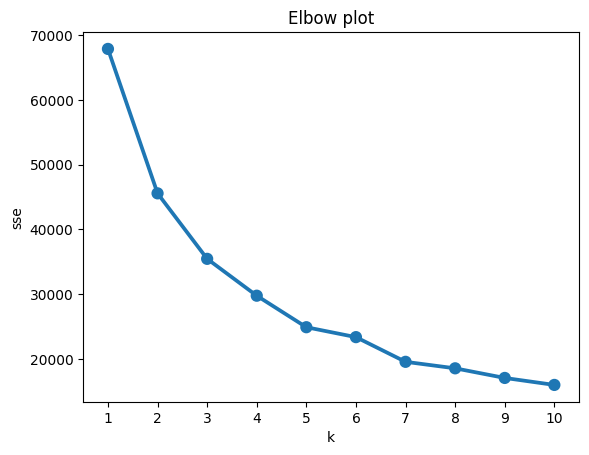

In [96]:
# choose approriate number of clusters:
from sklearn.cluster import KMeans
sse = {}
for k in range(1,11):
    kmeans = KMeans(n_clusters=k,n_init = 'auto',random_state=123)
    kmeans.fit(cluster_normalized)
    sse[k] = kmeans.inertia_

sns.pointplot(x=list(sse.keys()),y=list(sse.values()))
plt.xlabel('k')
plt.ylabel('sse')
plt.title('Elbow plot')
plt.show()

In [102]:
# choose k = 4:
kmeans = KMeans(n_clusters=4,n_init = 'auto',random_state=123)
kmeans.fit(cluster_normalized)
cluster_labels = kmeans.labels_
cluster_k4 = cluster.assign(Label = cluster_labels)
cluster_k4.groupby('Label').agg({'Recency':'mean','Frequency':'mean','Monetary':['mean','count']}).round(0)

Recency Frequency Monetary      
         mean      mean     mean count
Label                                 
0      202.0   1.0       5.0      9486
1      189.0   1.0       16.0     6436
2      17.0    7.0       9.0      3950
3      169.0   5.0       10.0     2753

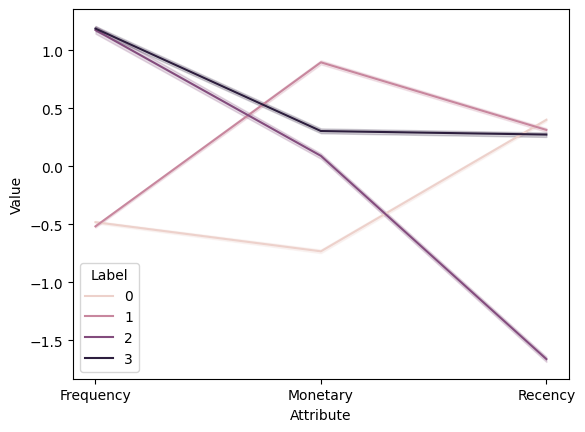

In [105]:
cluster_normalized = pd.DataFrame(cluster_normalized,index=cluster.index,columns=cluster.columns)
cluster_normalized['Label'] = cluster_k4['Label']
cluster_melt = pd.melt(cluster_normalized.reset_index(),
                      id_vars = ['Customer_ID','Label'],
                      value_vars = ['Frequency','Monetary','Recency'],
                      var_name = 'Attribute',
                      value_name = 'Value')
sns.lineplot(x='Attribute',y='Value',hue='Label',data=cluster_melt)
plt.show()

In [30]:
#PREPARE FOR POWER BI VISUALIZATION:
import pandas as pd
import numpy as np
from itertools import product
import re
recency = np.arange(1,6)
frequency = np.arange(1,6)
monetary = np.arange(1,6)
rfm = list(product(recency,frequency,monetary))
rfm_df = pd.DataFrame(rfm,columns=['r','f','m'])
rfm_df['rfm'] = rfm_df['r'].map(str) + rfm_df['f'].map(str) + rfm_df['m'].map(str)
rfm_df['rf'] = rfm_df['r'].map(str) + rfm_df['f'].map(str) 
seg_map = {
    r'5[4-5]':'champion',
    r'[3-4][4-5]':'loyal customer',
    r'[4-5][2-3]':'potential loyal',
    r'41':'promising',
    r'51':'new customer',
    r'33':'need attention',
    r'3[1-2]':'about to sleep',
    r'[1-2]5':'can\'t lose',
    r'[1-2][3-4]':'at risk',
    r'[1-2][1-2]':'hibernating'
}
rfm_df['segment'] = rfm_df['rf'].replace(seg_map,regex=True)
rfm_seg = rfm_df[['rfm','segment']]
rfm_seg.to_csv("C:/Users/Admin/Python/Dataset/rfm_seg.csv")